In [19]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [21]:
from project_modules.utils import get_logger
logger = get_logger("log-data-prep.log", level = logging.INFO)

[2024-01-28 19:49:23] [get_logger] Logger initialized.
[2024-01-28 19:49:23] [get_logger] Logging to file: log-data-prep.log


In [22]:
# read the parameter file

from project_modules.utils import read_parameters
parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

[2024-01-28 19:49:24] [read_parameters] Reading parameters.
[2024-01-28 19:49:24] [read_parameters] ... reading /Users/david/projects/lc-project-data/project.yaml


In [24]:
from pathlib import Path
input_dir = Path(parms["dir_raw_data"])
output_dir = Path(parms["dir_proc_data"])
fn = str(Path(input_dir, parms['file_raw_data']))

'/Users/david/projects/lc-project-data/raw-data/specimen-data.xlsx'

In [25]:
# master list of encoders and classes
encoder_dict = {}
classes_dict = {}

## Demographics

--------------------------------------------------
DEMOGRAPHICS
--------------------------------------------------
>>> Reading data from /Users/david/projects/lc-project-data/raw-data/specimen-data.xlsx,  sheet demographics
>>> Initial shape:   (20, 12)
>>> Index set using: UUID
>>> ... encoding 11 columns
>>> ... encoding multilabel column substances
>>> encoder_dict entries: 2
--------------------------------------------------
>>> Final shape:   (20, 15)
--------------------------------------------------
--------------------------------------------------
>>> DTYPE SUMMARY: 15 columns
--------------------------------------------------
>>> Column type counts
--------------------------------------------------
               int64:   15


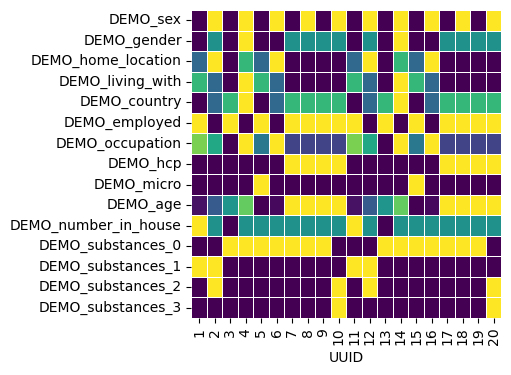

In [26]:
print(f'-'*50)
print(f'DEMOGRAPHICS')
print(f'-'*50)

from project_modules.data_prep import read_data, encode_features, multilabel_encoder, summarize_df, plot_df

section_tag = "DEMO"

# read the data
df = read_data(fn, sheet = "demographics", verbose = True, index_col = "UUID")

# remove the columns we want to treat as multilabel
to_multilabel  = ["substances"]
for_multilabel = df[to_multilabel]

# handle ordinal encoding
# this version requires a dataframe with the multilable columns removed
df = df.drop(columns = to_multilabel)
df, encoder = encode_features(
                                df, 
                                tag = section_tag, 
                                verbose = False
                                )

# update the encoder dictionary
encoder_dict[section_tag] = encoder

# handle multilabel encoding
if len(to_multilabel) > 0:
    for c in to_multilabel:
        mldf, mlencoder = multilabel_encoder(for_multilabel, c, section_tag, verbose = False)
        encoder_dict[f'{section_tag}_{c}'] = mlencoder
    # join the dfs
    demographics_df = df.join(mldf)
else:
    demographics_df = df

# print the results
print(f'>>> encoder_dict entries: {len(encoder_dict.keys())}')

print(f'-'*50)
print(f'>>> Final shape:   {demographics_df.shape}')
print(f'-'*50)

plot_df(demographics_df, verbose = True, figsize = (4,4))

summarize_df(demographics_df, verbose = False)

## Medical History

--------------------------------------------------
MEDICAL HISTORY
--------------------------------------------------
>>> Reading data from /Users/david/projects/lc-project-data/raw-data/specimen-data.xlsx,  sheet medhx
>>> Initial shape:   (20, 49)
>>> Index set using: UUID
>>> text columns: ['other', 'other_hhx']
>>> medication columns: ['Medication1', 'Medication2', 'Medication3', 'Medication4', 'Medication5', 'Medication6', 'Medication7', 'Medication8', 'Medication9', 'Medication10', 'Medication11', 'Medication12', 'Medication13', 'Medication14', 'Medication15']
>>> constructing binary columns for each unique medication
>>> 	- will add      12 NEW columns
>>> 	- will remove   15 OLD columns
>>> 	- net change    -3 columns
--------------------------------------------------
>>> Final shape:   (20, 46)
--------------------------------------------------
--------------------------------------------------
>>> DTYPE SUMMARY: 46 columns
--------------------------------------------------
>>

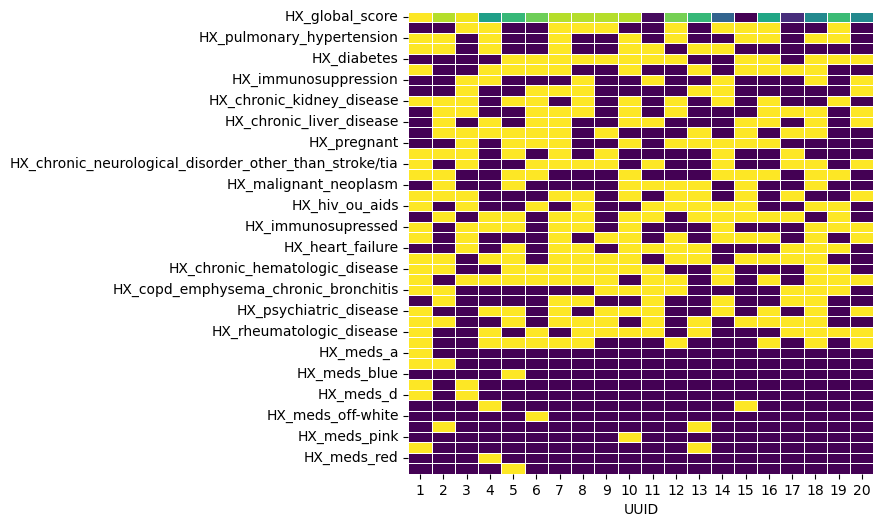

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

print(f'-'*50)
print(f'MEDICAL HISTORY')
print(f'-'*50)

section_tag = "HX"

# read the data
hx_df = read_data(fn, sheet = "medhx", verbose = True, index_col = "UUID")


# first, tidy the column names in this set
# replace all spaces in column names with underscores
# replace all parentheses and commas in column names with nothing
hx_df.columns = [col.replace(" ", "_")\
                    .replace("(", "")\
                    .replace(")", "")\
                    .replace(",", "") for col in hx_df.columns]

# make a list of column names that start with "Medication" or "other"

# other - these will be text fields - probably need to do some NLP on them
HX_text = [col for col in hx_df.columns if col.startswith("other") ]
print(f">>> text columns: {HX_text}")

# medications - there are 15 columns of these, and each patient
# could have between zero and 15 medications in the data set
HX_meds = [col for col in hx_df.columns if col.startswith("Medication")]
print(f">>> medication columns: {HX_meds}")


print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = hx_df[HX_meds].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(HX_meds):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(HX_meds):>4d} columns")



# use a multilabel binarizer to encode the values
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=hx_df.index)

encoder_dict[f"{section_tag}_meds"] = mlb

# now drop the original medication columns and 
# join the encoded medication dataframe
hx_df = hx_df.drop(columns = HX_meds).join(med_df)

# prepend HX to all column names
hx_df.columns = [f"{section_tag}_" + col.lower() for col in hx_df.columns]

print(f'-'*50)
print(f'>>> Final shape:   {hx_df.shape}')
print(f'-'*50)

plot_df(hx_df, verbose = True, figsize = (6,6))
summarize_df(hx_df, verbose = False)

## Clinical presentation

--------------------------------------------------
CLINICAL PRESENTATION
--------------------------------------------------
>>> Reading data from /Users/david/projects/lc-project-data/raw-data/specimen-data.xlsx,  sheet clinical
>>> Initial shape:   (20, 22)
>>> Index set using: UUID
>>> ... encoding 22 columns
>>> encoder_dict entries: 4
--------------------------------------------------
>>> Final shape:   (20, 22)
--------------------------------------------------
--------------------------------------------------
>>> DTYPE SUMMARY: 22 columns
--------------------------------------------------
>>> Column type counts
--------------------------------------------------
               int64:   10
      datetime64[ns]:    2
             float64:   10


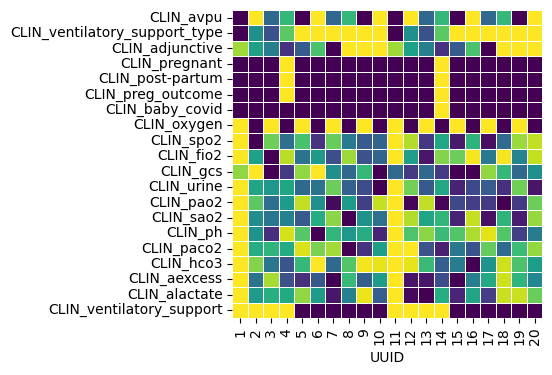

In [28]:
print(f'-'*50)
print(f'CLINICAL PRESENTATION')
print(f'-'*50)

section_tag = "CLIN"

# read the data
df = read_data(fn, sheet = "clinical", verbose = True, index_col = "UUID")

# remove the columns we want to treat as multilabel
to_multilabel  = []
for_multilabel = df[to_multilabel]

# handle ordinal encoding
# this version requires a dataframe with the multilable columns removed
df = df.drop(columns = to_multilabel)
df, encoder = encode_features(df, 
                                    tag = section_tag, 
                                    verbose = False
                                    )
encoder_dict[f"{section_tag}"] = encoder


# handle multilabel encoding
if len(to_multilabel) > 0:
    for c in to_multilabel:
        mldf, mlencoder = multilabel_encoder(for_multilabel, c, section_tag, verbose=False)
        encoder_dict[f"{section_tag}_{c}"] = mlencoder
    # join the dfs
    clinical_df = df.join(mldf)
else:
    clinical_df = df


# print the results
print(f'>>> encoder_dict entries: {len(encoder_dict.keys())}')

print(f'-'*50)
print(f'>>> Final shape:   {clinical_df.shape}')
print(f'-'*50)

plot_df(clinical_df, verbose = True, figsize = (4,4))
summarize_df(clinical_df, verbose = False)

## Lab results

--------------------------------------------------
LAB RESULTS
--------------------------------------------------
>>> Reading data from /Users/david/projects/lc-project-data/raw-data/specimen-data.xlsx,  sheet labs
>>> Initial shape:   (20, 60)
>>> Index set using: UUID
--------------------------------------------------
>>> Final shape:   (20, 60)
--------------------------------------------------
--------------------------------------------------
>>> DTYPE SUMMARY: 60 columns
--------------------------------------------------
>>> Column type counts
--------------------------------------------------
      datetime64[ns]:    1
             float64:   45
               int64:   14


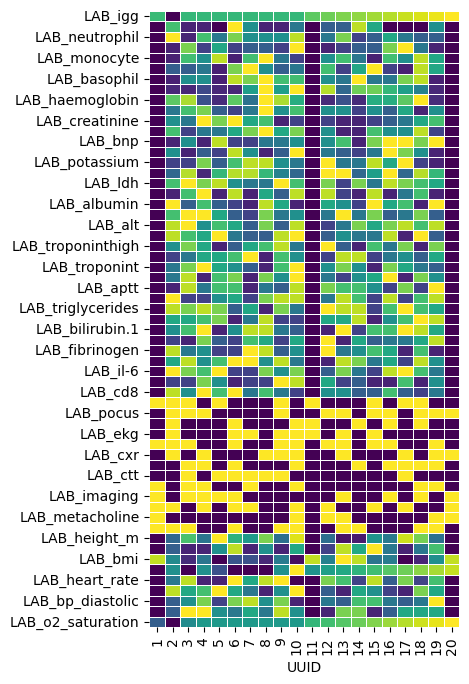

In [29]:
print(f'-'*50)
print(f'LAB RESULTS')
print(f'-'*50)

section_tag = "LAB"

# read the data
df = read_data(fn, sheet = "labs", verbose = True, index_col = "UUID")

# prepend LAB to all column names
df.columns = [f"{section_tag}_" + col.lower() for col in df.columns]

lab_df = df

# other than that, nothing to do here
print(f'-'*50)
print(f'>>> Final shape:   {lab_df.shape}')
print(f'-'*50)

plot_df(lab_df, figsize = (4,8))
summarize_df(lab_df)

## Save demographics, labs, history, and clinical presentation to datasets format

In [30]:
# def make_save_path(od: Path, fn: str):
#     """
#     make a save path from the output directory and the filename
#     """
#     return str(Path(od, fn))

In [31]:
# convert to dataset format and save
from datasets import Dataset

demographics_dataset = Dataset.from_pandas(demographics_df)
# demographics_dataset.save_to_disk(make_save_path(output_dir, "demographics_dataset"))

labs_dataset = Dataset.from_pandas(lab_df)
# labs_dataset.save_to_disk(make_save_path(output_dir, "labs_dataset"))

hx_dataset = Dataset.from_pandas(hx_df)
# hx_dataset.save_to_disk(make_save_path(output_dir, "hx_dataset"))

clinical_dataset = Dataset.from_pandas(clinical_df)
# clinical_dataset.save_to_disk(make_save_path(output_dir, "clinical_dataset"))

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [32]:
# make a datasetdict and save
from datasets import DatasetDict

dataset_dict = DatasetDict({
    "demographics": demographics_dataset,
    "labs": labs_dataset,
    "hx": hx_dataset,
    "clinical": clinical_dataset
})

# dataset_dict.save_to_disk(make_save_path(output_dir, "dataset_dict"))
dataset_dict.save_to_disk(Path(output_dir, "dataset_dict"))

In [33]:
# safely pickle the dictionary of encoders
import pickle
from pprint import pprint

# prettyprint the encoder_dict
pprint(encoder_dict, indent = 4)

op = str(Path(output_dir, "encoder_dict.pkl"))

with open(op, "wb") as f:
    pickle.dump(encoder_dict, f)

{   'CLIN': OrdinalEncoder(dtype=<class 'numpy.int64'>),
    'DEMO': OrdinalEncoder(dtype=<class 'numpy.int64'>),
    'DEMO_substances': MultiLabelBinarizer(),
    'HX_meds': MultiLabelBinarizer()}


In [34]:
from project_modules.data_prep import summarize_encoder

summarize_encoder(encoder_dict, verbose = False)

>>> OrdinalEncoder DEMO: 9
>>> 	Feature: sex                            Encoded Classes ['F' 'M']
>>> 	Feature: gender                         Encoded Classes ['a' 'b' 'c']
>>> 	Feature: home_location                  Encoded Classes ['CHSLD' 'HOME' 'INTERMEDIATE' 'RPA']
>>> 	Feature: living_with                    Encoded Classes ['ALONE' 'CARETAKER' 'FAMILY' 'ROOM-MATE']
>>> 	Feature: country                        Encoded Classes ['AA' 'BB' 'CC' 'DD']
>>> 	Feature: employed                       Encoded Classes ['no' 'yes']
>>> 	Feature: occupation                     Encoded Classes ['accountant' 'doctor' 'lab tech' 'lawyer' 'miner' 'truck driver']
>>> 	Feature: hcp                            Encoded Classes ['no' 'yes']
>>> 	Feature: micro                          Encoded Classes ['no' 'yes']
>>> MultiLabelBinarizer DEMO_substances: 4
>>> 	Encoded Classes: 	DEMO_substances_0
>>> 	Encoded Classes: 	DEMO_substances_1
>>> 	Encoded Classes: 	DEMO_substances_2
>>> 	Encoded Classes: 	DE